# 2a - Co-repost networks
In this notebook we will create a network of co-reposts, i.e., a network where two users are connected if they reposted the same posts.
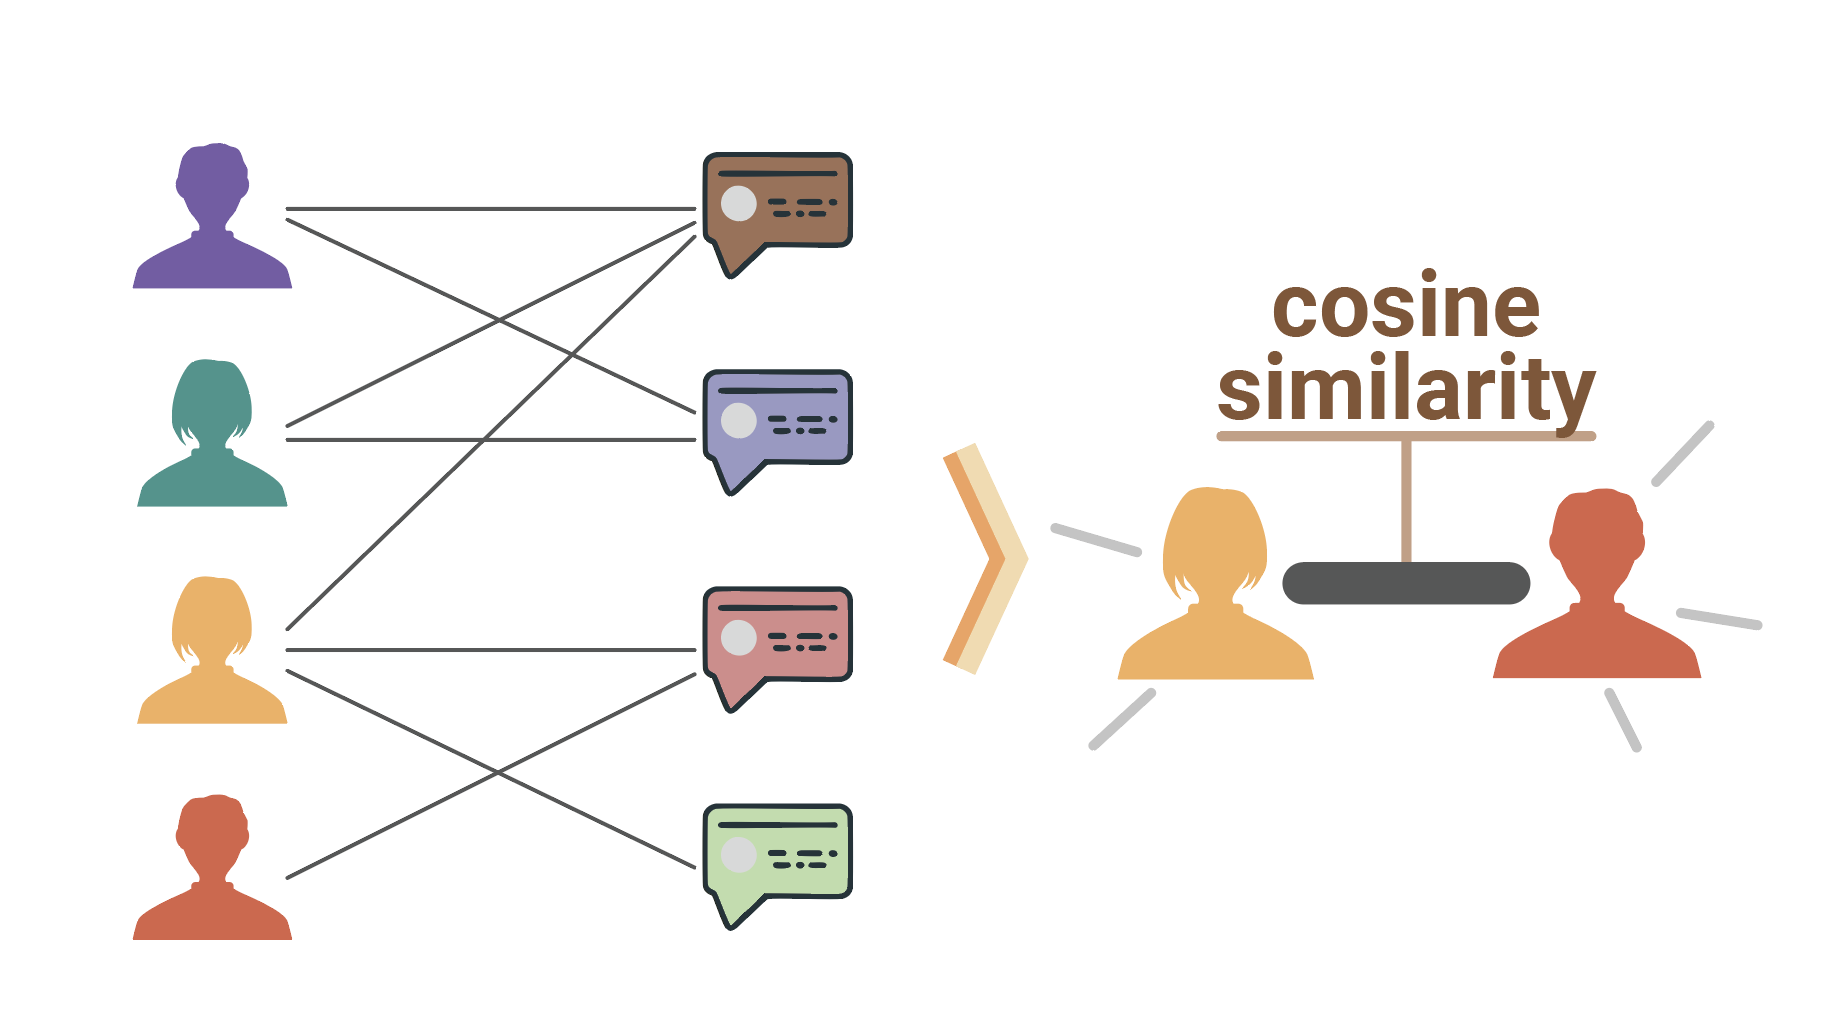

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from pathlib import Path
import gzip
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer

from scipy.sparse import csr_matrix
import igraph as ig
import xnetwork as xn

Let's select the dataset and load the data.

We are keeping users only with a minimum number of activities.

In [ ]:
datasetName = "debate2024_Jun_bluesky"
dataPath = Path("Data")
networksPath = dataPath/"Networks"
networksPath.mkdir(parents=True, exist_ok=True)
# Minimum number of activities for a user to be considered
minUserActivities = 5

In [ ]:
with gzip.open(dataPath / f"{datasetName}.feather.gz", 'rb') as f:
    df = pd.read_feather(f)

Filtering users by the min number of activities is important to avoid a very dense network and spuriously connected users.

In [ ]:
userActivityCount = df["user_id"].value_counts()
usersWithMinActivities = set(userActivityCount[userActivityCount >= minUserActivities].index)
dfFiltered = df[df["user_id"].isin(usersWithMinActivities)]

This function creates the bipartite network of users and reposts. The output is a list of edges, where each edge is a tuple with a `user_id` and a `post_id`.

In [ ]:
def obtainBipartiteEdgesReposts(df):
    if "linked_post" not in df or "post_type" not in df or "user_id" not in df:
        return []
    df = df[df["post_type"] == "repost"]
    bipartiteEdges = df[["user_id","linked_post"]].values
    return bipartiteEdges

In [ ]:
bipartiteEdges = obtainBipartiteEdgesReposts(dfFiltered)

We can also filter nodes by the minimum number of activities respective to the type of node (user or post). For instance, we can filter out users with less than 10 reposts and posts with less than 10 reposts.

In [ ]:
def filterNodes(bipartiteEdges, minRightDegree=1, minLeftDegree=1):
    # goes from right to left
    bipartiteEdges = np.array(bipartiteEdges)
    mask = np.ones(len(bipartiteEdges),dtype=bool)
    if(minRightDegree>1):
        uniqueEdges = set(tuple(edge) for edge in bipartiteEdges)
        uniqueEdges = np.array(list(uniqueEdges))
        rightDegrees = Counter(uniqueEdges[:,1])
        mask &= np.array([rightDegrees[rightNode]>=minRightDegree for _,rightNode in bipartiteEdges])
    bipartiteEdges = bipartiteEdges[mask]
    
    # goes from left to right
    mask = np.ones(len(bipartiteEdges),dtype=bool)
    if(minLeftDegree>1):
        uniqueEdges = set(tuple(edge) for edge in bipartiteEdges)
        uniqueEdges = np.array(list(uniqueEdges))
        leftDegrees = Counter(uniqueEdges[:,0])
        mask &= np.array([leftDegrees[leftNode]>=minLeftDegree for leftNode,_ in bipartiteEdges])
    bipartiteEdges = bipartiteEdges[mask]
    return bipartiteEdges

In [ ]:
bipartiteEdges = filterNodes(bipartiteEdges, minRightDegree=5, minLeftDegree=5)

To make things faster, we need index all the ids and create a dictionary to map the ids to the index.
 - Left = users
 - Right = posts

In [ ]:
bipartiteEdges = np.array(bipartiteEdges)
bipartiteIndexedEdges = np.zeros(bipartiteEdges.shape, dtype=int)
leftIndex2Label = [label for label in np.unique(bipartiteEdges[:,0])]
leftLabel2Index = {label: index for index, label in enumerate(leftIndex2Label)}
rightIndex2Label = [label for label in np.unique(bipartiteEdges[:,1])]
rightLabel2Index = {label: index for index, label in enumerate(rightIndex2Label)}

# create indexed edges in a numpy array integers
bipartiteIndexedEdges[:,0] = [leftLabel2Index[label] for label in bipartiteEdges[:,0]]
bipartiteIndexedEdges[:,1] = [rightLabel2Index[label] for label in bipartiteEdges[:,1]]

leftCount = len(leftIndex2Label)
rightCount = len(rightIndex2Label)

leftIndexedDegree = np.bincount(bipartiteIndexedEdges[:,0])
rightIndexedDegree = np.bincount(bipartiteIndexedEdges[:,1])


In [ ]:
bipartiteIndexedEdges[0:5]

We can use cosine similarity to measure the similarity between users. The similarity between two users is the cosine similarity between the repost vectors of the users.
<!-- tfidf -->
However, in that case, posts that are reposted by many users will be more likely to connect users. To avoid this, we can use the IDF term of the TF-IDF to downweight the posts that are reposted by many users.

In it's smooth version, idf is calculcated as:
$ \text{idf}(t) = \log\left(\frac{N+1}{\text{df}(t)+1}\right) + 1 $

Where:
 - $N$ is the total number of users
 - $\text{df}(t)$ is the number of users that reposted the post $t$.

All of this can be done using sparse matrices and helper functions from the `scipy` library.

In [ ]:
weightsMatrix = csr_matrix((np.ones(len(bipartiteIndexedEdges)), (bipartiteIndexedEdges[:,0], bipartiteIndexedEdges[:,1])), shape=(leftCount, rightCount))
vectorizer = TfidfTransformer()
weightsMatrix = vectorizer.fit_transform(weightsMatrix)


In [ ]:
similarities = cosine_similarity(weightsMatrix)

Thresholding is important to avoid a very dense network and spuriously connected users.
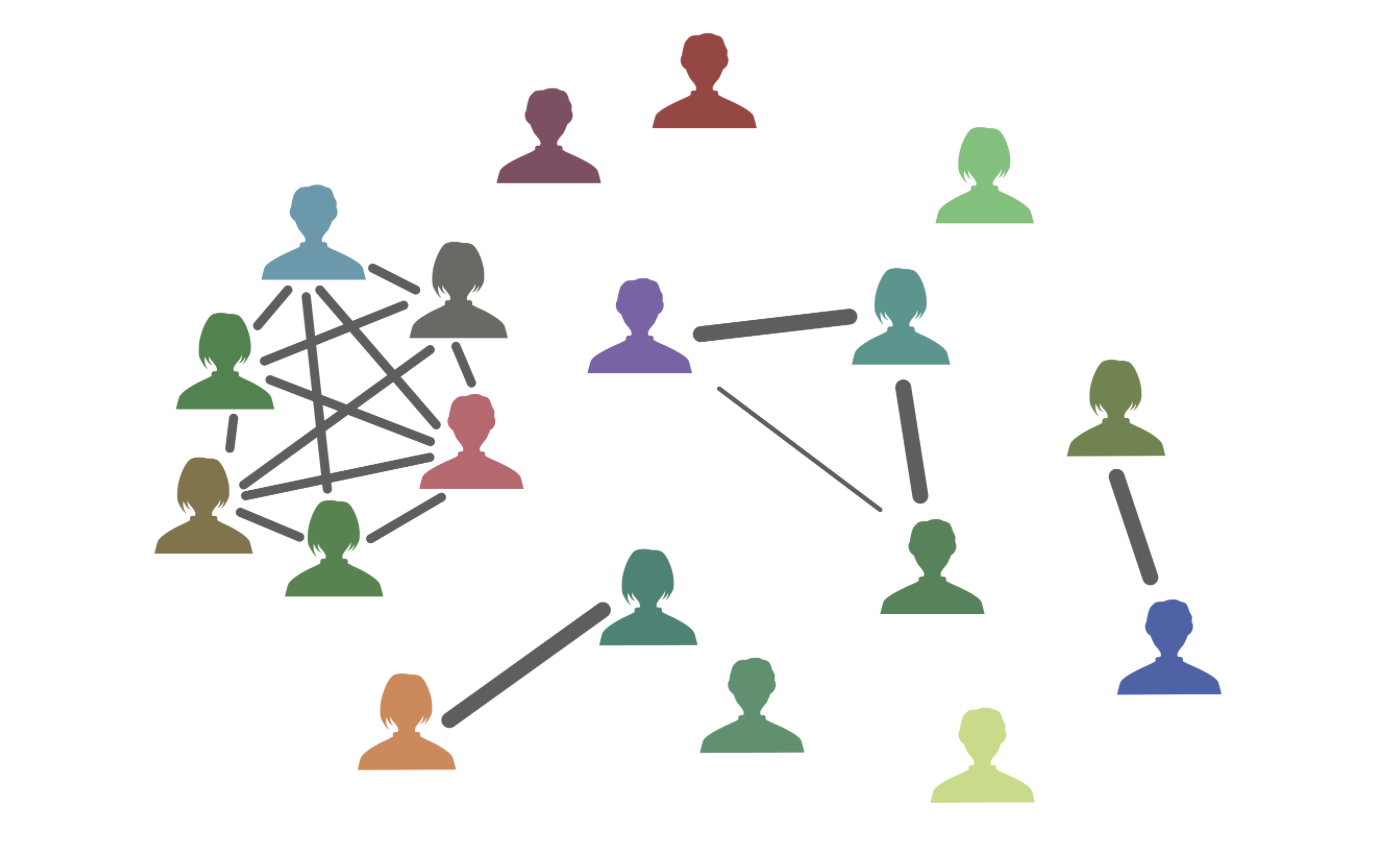

There are many ways to threshold the similarity matrix. We can use a fixed threshold, a percentile, disparity filter.

Here we will adopt a fixed threshold for simplicity.

In [ ]:
# Apply a threshold to the similarities
threshold = 0.1
similarities[similarities<threshold] = 0
# remove diagonal
np.fill_diagonal(similarities, 0)

We will create an igraph object for the network.

More information about igraph can be found here: https://igraph.org

In [ ]:
g = ig.Graph.Weighted_Adjacency(similarities, mode="undirected", attr="weight")

In [ ]:
{
 "Number of nodes":g.vcount(),
 "Number of edges":g.ecount(),
 "Avg. degree": 2.0*g.ecount()/g.vcount()
 }

We can assign node attributes to the igraph object. For instance, we can assign the user name to the user nodes.

In [ ]:
g.vs["Label"] = leftIndex2Label
# original number of posts
g.vs["RepostsCount"] = leftIndexedDegree

Let's also get some unique reposts by each user according to idf.

In [ ]:
postID2Text = dict(zip(df["post_id"], df["text"]))
topRepostIndices = np.argmax(weightsMatrix, axis=1)
g.vs["MostUniqueRepost"] = [postID2Text[rightIndex2Label[index]] for index in topRepostIndices.A.ravel()]

And some sampled reposts as well.

In [ ]:
user2repostIDs = dfFiltered[dfFiltered["post_type"]=="repost"].groupby("user_id")["linked_post"].apply(list)
user2samplePostText = user2repostIDs.apply(lambda repostIDs: "<br>".join(np.random.choice([postID2Text[postID] for postID in repostIDs], size=min(len(repostIDs),3), replace=False)))
g.vs["SampleReposts"] = [user2samplePostText.get(label, "") for label in leftIndex2Label]

Removing isolated nodes

In [ ]:
gFiltered = g.subgraph(g.vs.select(_degree_gt=0))

Saving the network to xnet format.

https://github.com/filipinascimento/xnet

In [ ]:
# save to XNET
xn.save(g, networksPath/f"{datasetName}_corepost.xnet")